c:\Users\Admin\AppData\Local\Programs\Python\Python311\Lib\site-packages\torch\nn\modules\transformer.py:385: UserWarning: enable_nested_tensor is True, but self.use_nested_tensor is False because encoder_layer.self_attn.batch_first was not True(use batch_first for better inference performance)
  warnings.warn(


Epoch 1/50, Train Loss: 0.057700, Val Loss: 0.023212
Epoch 2/50, Train Loss: 0.006589, Val Loss: 0.010452
Epoch 3/50, Train Loss: 0.004544, Val Loss: 0.004275
Epoch 4/50, Train Loss: 0.003085, Val Loss: 0.003369
Epoch 5/50, Train Loss: 0.002555, Val Loss: 0.002789
Epoch 6/50, Train Loss: 0.002063, Val Loss: 0.002896
Epoch 7/50, Train Loss: 0.001625, Val Loss: 0.002589
Epoch 8/50, Train Loss: 0.001501, Val Loss: 0.002764
Epoch 9/50, Train Loss: 0.001289, Val Loss: 0.003066
Epoch 10/50, Train Loss: 0.001191, Val Loss: 0.002128
Epoch 11/50, Train Loss: 0.001079, Val Loss: 0.002121
Epoch 12/50, Train Loss: 0.000780, Val Loss: 0.003976
Epoch 13/50, Train Loss: 0.000789, Val Loss: 0.001840
Epoch 14/50, Train Loss: 0.001110, Val Loss: 0.005447
Epoch 15/50, Train Loss: 0.000739, Val Loss: 0.001951
Epoch 16/50, Train Loss: 0.000615, Val Loss: 0.002629
Epoch 17/50, Train Loss: 0.000572, Val Loss: 0.001578
Epoch 18/50, Train Loss: 0.000468, Val Loss: 0.005072
Epoch 19/50, Train Loss: 0.000533, Va

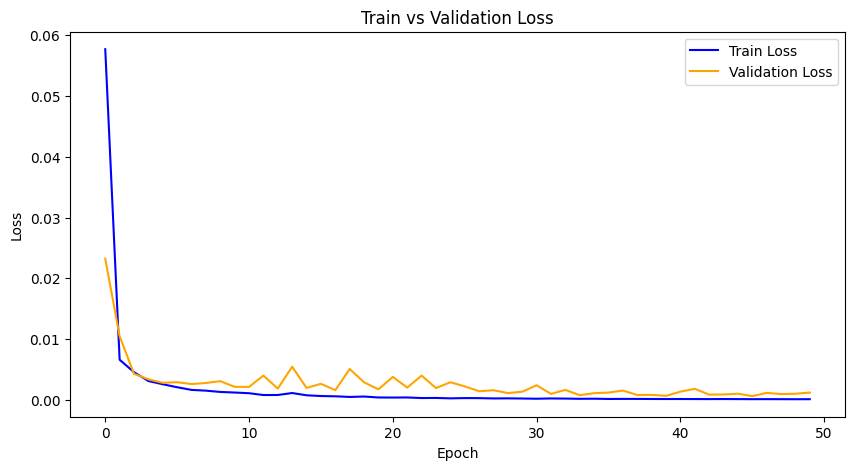

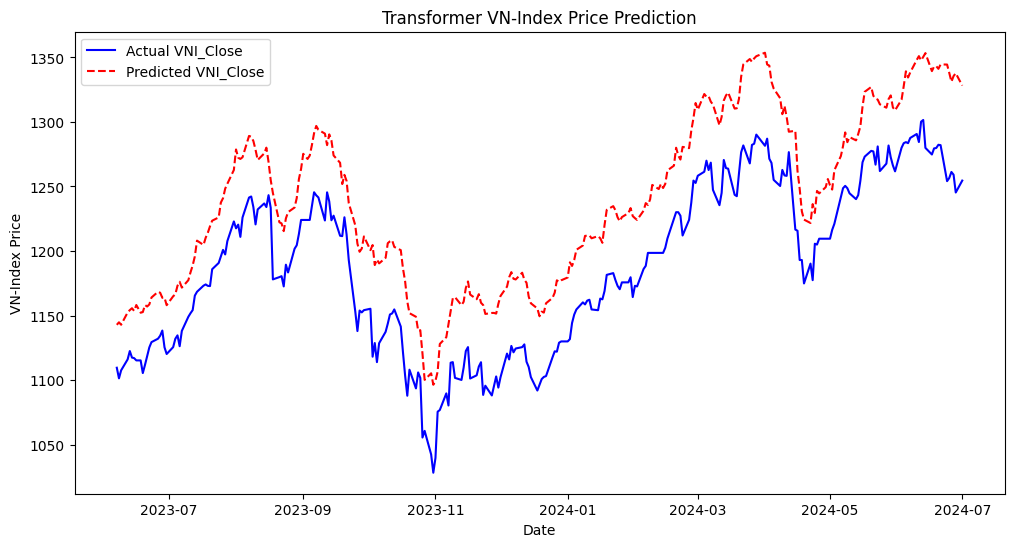

In [8]:
import numpy as np
import pandas as pd
import torch
import torch.nn as nn
import torch.optim as optim
import matplotlib.pyplot as plt
from sklearn.preprocessing import MinMaxScaler
from torch.utils.data import DataLoader, TensorDataset

# Đọc dữ liệu
df = pd.read_csv(r"C:\Users\Admin\Downloads\NCKH_\MODEL\Data\data.csv")

# Chuyển đổi cột Date thành datetime và đặt làm index
df['Date'] = pd.to_datetime(df['Date'], format="%m/%d/%Y")
df.set_index('Date', inplace=True)

# Xác định cột mục tiêu và features
target_col = 'VNI_Close price'
feature_cols = [col for col in df.columns if col != target_col]

# Chuẩn hóa dữ liệu
scaler = MinMaxScaler()
df_scaled = pd.DataFrame(scaler.fit_transform(df), columns=df.columns, index=df.index)

# Chia tập dữ liệu
train_size = int(len(df) * 0.8)
val_size = int(len(df) * 0.1)

train_data = df_scaled.iloc[:train_size]
val_data = df_scaled.iloc[train_size:train_size + val_size]
test_data = df_scaled.iloc[train_size + val_size:]

# Hàm tạo sequences
def create_sequences(data, seq_length=60):
    sequences, targets = [], []
    data_values = data.values
    for i in range(len(data) - seq_length):
        sequences.append(data_values[i:i + seq_length])
        targets.append(data_values[i + seq_length][data.columns.get_loc(target_col)])
    return torch.tensor(np.array(sequences), dtype=torch.float32), torch.tensor(targets, dtype=torch.float32)

# Tạo dữ liệu
seq_length = 60
X_train, y_train = create_sequences(train_data, seq_length)
X_val, y_val = create_sequences(val_data, seq_length)
X_test, y_test = create_sequences(test_data, seq_length)

# Tạo DataLoader
batch_size = 32
train_loader = DataLoader(TensorDataset(X_train, y_train), batch_size=batch_size, shuffle=True)
val_loader = DataLoader(TensorDataset(X_val, y_val), batch_size=batch_size, shuffle=False)
test_loader = DataLoader(TensorDataset(X_test, y_test), batch_size=batch_size, shuffle=False)

# Mô hình Transformer
class TransformerModel(nn.Module):
    def __init__(self, input_dim, seq_length, d_model=128, nhead=8, num_layers=2, dim_feedforward=256):
        super(TransformerModel, self).__init__()
        self.input_dim = input_dim
        self.d_model = d_model

        self.embedding = nn.Linear(input_dim, d_model)
        self.pos_embedding = nn.Parameter(torch.randn(1, seq_length, d_model))

        encoder_layer = nn.TransformerEncoderLayer(d_model=d_model, nhead=nhead, dim_feedforward=dim_feedforward)
        self.transformer_encoder = nn.TransformerEncoder(encoder_layer, num_layers=num_layers)

        self.fc = nn.Linear(d_model, 1)

    def forward(self, x):
        x = self.embedding(x) + self.pos_embedding
        x = self.transformer_encoder(x)
        x = x[:, -1, :]  # Lấy vector cuối cùng để dự đoán
        out = self.fc(x)
        return out.squeeze()

# Khởi tạo mô hình
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
input_size = X_train.shape[2]
model = TransformerModel(input_dim=input_size, seq_length=seq_length).to(device)

criterion = nn.MSELoss()
optimizer = optim.Adam(model.parameters(), lr=0.0005, weight_decay=1e-3)

train_losses = []
val_losses = []

# Huấn luyện mô hình
num_epochs = 50
for epoch in range(num_epochs):
    model.train()
    epoch_train_loss = 0
    for batch_X, batch_y in train_loader:
        batch_X, batch_y = batch_X.to(device), batch_y.to(device)
        optimizer.zero_grad()
        y_pred = model(batch_X)
        loss = criterion(y_pred, batch_y)
        loss.backward()
        optimizer.step()
        epoch_train_loss += loss.item()
    
    train_losses.append(epoch_train_loss / len(train_loader))
    
    # Validation loss
    model.eval()
    epoch_val_loss = 0
    with torch.no_grad():
        for batch_X, batch_y in val_loader:
            batch_X, batch_y = batch_X.to(device), batch_y.to(device)
            y_pred = model(batch_X)
            loss = criterion(y_pred, batch_y)
            epoch_val_loss += loss.item()
    
    val_losses.append(epoch_val_loss / len(val_loader))
    print(f"Epoch {epoch+1}/{num_epochs}, Train Loss: {train_losses[-1]:.6f}, Val Loss: {val_losses[-1]:.6f}")

# Lưu mô hình
torch.save(model.state_dict(), "transformer_advanced_2.pth")
print("✅ Training hoàn tất! Mô hình đã được lưu.")

# Vẽ biểu đồ Train vs Validation Loss
plt.figure(figsize=(10, 5))
plt.plot(train_losses, label="Train Loss", color='blue')
plt.plot(val_losses, label="Validation Loss", color='orange')
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.title("Train vs Validation Loss")
plt.legend()
plt.show()

# Dự đoán trên tập test
model.eval()
predictions = []
actuals = []

with torch.no_grad():
    for batch_X, batch_y in test_loader:
        batch_X = batch_X.to(device)
        y_pred = model(batch_X)
        predictions.extend(y_pred.cpu().numpy())
        actuals.extend(batch_y.numpy())

# Chuyển về giá trị gốc
actuals = np.array(actuals).reshape(-1, 1)
predictions = np.array(predictions).reshape(-1, 1)

scaler_target = MinMaxScaler()
scaler_target.fit(df[[target_col]])
actuals = scaler_target.inverse_transform(actuals)
predictions = scaler_target.inverse_transform(predictions)

# Vẽ biểu đồ Actual vs Predicted
plt.figure(figsize=(12, 6))
plt.plot(df.index[-len(actuals):], actuals, label="Actual VNI_Close", color='blue')
plt.plot(df.index[-len(predictions):], predictions, label="Predicted VNI_Close", color='red', linestyle='dashed')
plt.xlabel("Date")
plt.ylabel("VN-Index Price")
plt.legend()
plt.title("Transformer VN-Index Price Prediction")
plt.show()


In [12]:
from sklearn.metrics import mean_absolute_error, mean_squared_error

# Tính các chỉ số đánh giá
mae = mean_absolute_error(actuals, predictions)
mse = mean_squared_error(actuals, predictions)
rmse = np.sqrt(mse)

print(f"Test MAE: {mae:.2f}")
print(f"Test MSE: {mse:.2f}")
print(f"Test RMSE: {rmse:.2f}")

Test MAE: 50.41
Test MSE: 2690.07
Test RMSE: 51.87


### **OUT OF SAMPLE PREDICTION**

c:\Users\Admin\AppData\Local\Programs\Python\Python311\Lib\site-packages\torch\nn\modules\transformer.py:385: UserWarning: enable_nested_tensor is True, but self.use_nested_tensor is False because encoder_layer.self_attn.batch_first was not True(use batch_first for better inference performance)
  warnings.warn(


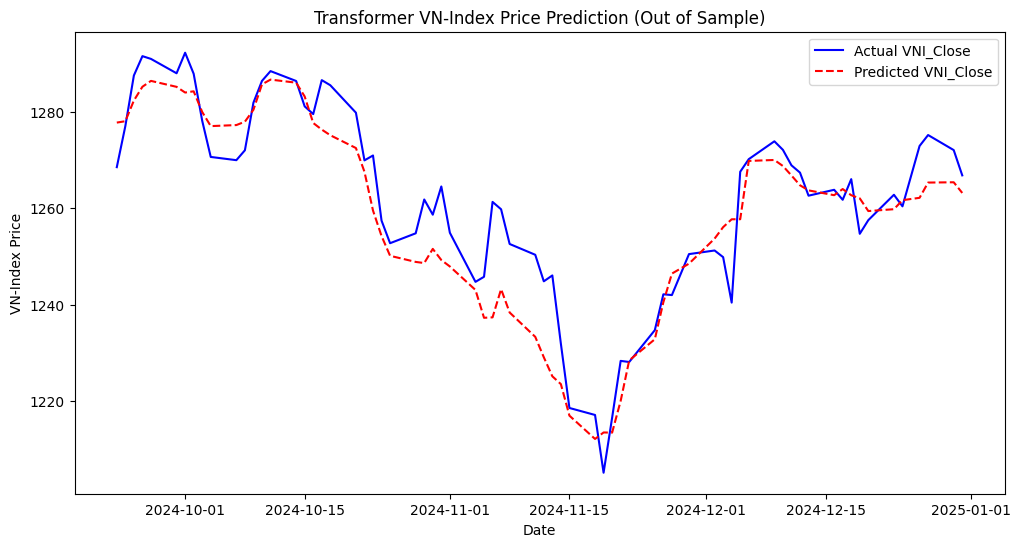

In [13]:
import torch
import torch.nn as nn
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_absolute_error, mean_squared_error


file_path = r"C:\Users\Admin\Downloads\NCKH_\MODEL\Data\data_OOS_2.csv"
df_oos = pd.read_csv(file_path)

# Loại bỏ các cột không cần thiết
drop_cols = ['VNI_Open price', 'VNI_High price', 'VNI_Low price']
df_oos.drop(columns=drop_cols, inplace=True)

# Chuyển đổi cột 'Date' thành datetime và đặt làm index
df_oos['Date'] = pd.to_datetime(df_oos['Date'], format="%m/%d/%Y")
df_oos.set_index('Date', inplace=True)

# Xác định cột mục tiêu và features
target_col = "VNI_Close price"
feature_cols = [col for col in df_oos.columns if col != target_col]

# Chuẩn hóa dữ liệu (scale riêng features và target)
scaler_features = MinMaxScaler()
scaler_target = MinMaxScaler()

df_oos_scaled = df_oos.copy()
df_oos_scaled[feature_cols] = scaler_features.fit_transform(df_oos[feature_cols])
df_oos_scaled[[target_col]] = scaler_target.fit_transform(df_oos[[target_col]])

# Hàm tạo sequences
def create_sequences(data, seq_length=60):
    sequences, targets = [], []
    data_values = data.values
    for i in range(len(data) - seq_length):
        sequences.append(data_values[i:i + seq_length])
        targets.append(data_values[i + seq_length][data.columns.get_loc(target_col)])
    return torch.tensor(np.array(sequences), dtype=torch.float32), torch.tensor(targets, dtype=torch.float32)

# Tạo dữ liệu OOS
seq_length = 60
X_oos, y_oos = create_sequences(df_oos_scaled, seq_length)

# -------------------- Định nghĩa Mô hình Transformer --------------------
class TransformerModel(nn.Module):
    def __init__(self, input_dim, seq_length, d_model=128, nhead=8, num_layers=2, dim_feedforward=256):
        super(TransformerModel, self).__init__()
        self.input_dim = input_dim
        self.d_model = d_model

        self.embedding = nn.Linear(input_dim, d_model)
        self.pos_embedding = nn.Parameter(torch.randn(1, seq_length, d_model))

        encoder_layer = nn.TransformerEncoderLayer(d_model=d_model, nhead=nhead, dim_feedforward=dim_feedforward)
        self.transformer_encoder = nn.TransformerEncoder(encoder_layer, num_layers=num_layers)

        self.fc = nn.Linear(d_model, 1)

    def forward(self, x):
        x = self.embedding(x) + self.pos_embedding
        x = self.transformer_encoder(x)
        x = x[:, -1, :]  # Lấy vector cuối cùng để dự đoán
        out = self.fc(x)
        return out.squeeze()

# -------------------- Load mô hình đã train --------------------
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
input_size = X_oos.shape[2]
model = TransformerModel(input_dim=input_size, seq_length=seq_length).to(device)

# Load trọng số đã huấn luyện
model.load_state_dict(torch.load("transformer_advanced_2.pth", map_location=device))
model.eval()

# -------------------- Dự đoán trên tập OOS --------------------
batch_size = 32
predictions_oos = []

with torch.no_grad():
    for i in range(0, len(X_oos), batch_size):
        batch_X = X_oos[i:i + batch_size].to(device)
        y_pred = model(batch_X).cpu().numpy()
        predictions_oos.extend(y_pred)

# Chuyển về giá trị gốc
predictions_oos = np.array(predictions_oos).reshape(-1, 1)
predictions_oos = scaler_target.inverse_transform(predictions_oos)

# Giá trị thực tế
actuals_oos = df_oos[target_col].iloc[-len(predictions_oos):].values.reshape(-1, 1)
# -------------------- Tạo DataFrame Kết quả --------------------
df_results = pd.DataFrame({
    "Date": df_oos.index[-len(predictions_oos):],
    "Actual": actuals_oos.flatten(),
    "Predicted": predictions_oos.flatten(),
    "Error": np.abs(actuals_oos.flatten() - predictions_oos.flatten())
})
df_results.set_index("Date", inplace=True)
# -------------------- Vẽ biểu đồ Actual vs Predicted OOS --------------------
plt.figure(figsize=(12, 6))
plt.plot(df_results.index, df_results["Actual"], label="Actual VNI_Close", color='blue')
plt.plot(df_results.index, df_results["Predicted"], label="Predicted VNI_Close", color='red', linestyle='dashed')

plt.xlabel("Date")
plt.ylabel("VN-Index Price")
plt.title("Transformer VN-Index Price Prediction (Out of Sample)")
plt.legend()
plt.show()

In [11]:

# -------------------- Tính toán các chỉ số lỗi --------------------
mae = mean_absolute_error(actuals_oos, predictions_oos)
mse = mean_squared_error(actuals_oos, predictions_oos)
rmse = np.sqrt(mse)
mape = np.mean(np.abs((actuals_oos - predictions_oos) / actuals_oos)) * 100

print(f"📊 MAE: {mae:.4f}")
print(f"📊 MSE: {mse:.4f}")
print(f"📊 RMSE: {rmse:.4f}")
print(f"📊 MAPE: {mape:.2f}%")

# -------------------- Tạo DataFrame Kết quả --------------------
df_results = pd.DataFrame({
    "Date": df_oos.index[-len(predictions_oos):],
    "Actual": actuals_oos.flatten(),
    "Predicted": predictions_oos.flatten(),
    "Error": np.abs(actuals_oos.flatten() - predictions_oos.flatten())
})
df_results.set_index("Date", inplace=True)
print(df_results.head())



📊 MAE: 6.1475
📊 MSE: 65.3580
📊 RMSE: 8.0844
📊 MAPE: 0.49%
             Actual    Predicted     Error
Date                                      
2024-09-23  1268.48  1277.720215  9.240215
2024-09-24  1276.99  1278.003296  1.013296
2024-09-25  1287.48  1282.290039  5.189961
2024-09-26  1291.49  1285.147949  6.342051
2024-09-27  1290.92  1286.362305  4.557695


In [16]:
df_results

,Actual,Predicted,Error
Date,,,
2024-09-23,1268.48,1277.720215,9.240215
2024-09-24,1276.99,1278.003296,1.013296
2024-09-25,1287.48,1282.290039,5.189961
2024-09-26,1291.49,1285.147949,6.342051
2024-09-27,1290.92,1286.362305,4.557695
...,...,...,...
2024-12-24,1260.36,1261.638794,1.278794
2024-12-26,1272.87,1262.126221,10.743779
2024-12-27,1275.14,1265.288330,9.851670


In [17]:
df_results.to_csv("transformer_advanced_OOS_predictions.csv")

Baseline RMSE: 0.0707


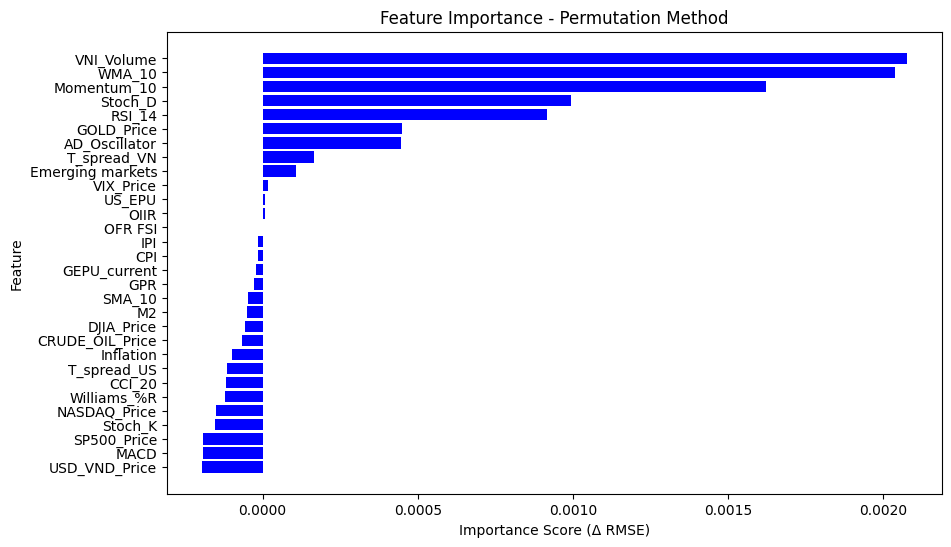

In [7]:
from sklearn.metrics import mean_squared_error
import copy

# Dự đoán ban đầu trên tập test (để lấy baseline RMSE)
model.eval()
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

with torch.no_grad():
    predictions = model(X_test.to(device)).cpu().numpy()
baseline_rmse = np.sqrt(mean_squared_error(y_test.numpy(), predictions))
print(f"Baseline RMSE: {baseline_rmse:.4f}")

# Tính Feature Importance bằng cách hoán đổi từng feature
feature_importance = {}
for i, feature in enumerate(feature_cols):
    X_test_permuted = X_test.clone()
    np.random.shuffle(X_test_permuted[:, :, i].numpy())  # Xáo trộn feature thứ i

    # Dự đoán lại
    with torch.no_grad():
        permuted_predictions = model(X_test_permuted.to(device)).cpu().numpy()
    
    # Tính RMSE sau khi hoán đổi
    permuted_rmse = np.sqrt(mean_squared_error(y_test.numpy(), permuted_predictions))
    importance_score = permuted_rmse - baseline_rmse  # Feature nào làm tăng RMSE nhiều là quan trọng hơn
    feature_importance[feature] = importance_score

# Sắp xếp theo độ quan trọng giảm dần
sorted_features = sorted(feature_importance.items(), key=lambda x: x[1], reverse=True)

# Vẽ biểu đồ Feature Importance
plt.figure(figsize=(10, 6))
plt.barh([x[0] for x in sorted_features], [x[1] for x in sorted_features], color='blue')
plt.xlabel("Importance Score (Δ RMSE)")
plt.ylabel("Feature")
plt.title("Feature Importance - Permutation Method")
plt.gca().invert_yaxis()  # Đảo ngược để feature quan trọng nhất ở trên cùng
plt.show()


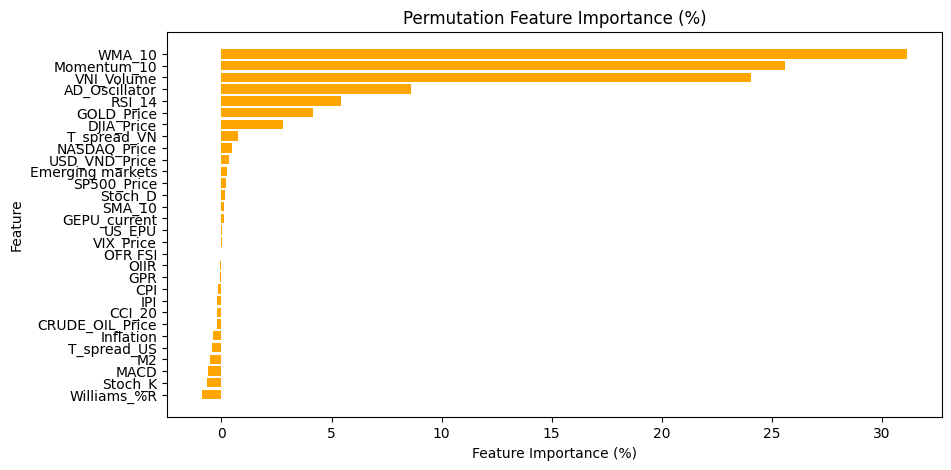

In [14]:
from sklearn.metrics import mean_squared_error

def permutation_importance(model, X_test, y_test, feature_cols, scaler_target):
    baseline_preds = model(X_test.to(device)).cpu().detach().numpy()
    baseline_preds = scaler_target.inverse_transform(baseline_preds.reshape(-1, 1))
    y_test = scaler_target.inverse_transform(y_test.numpy().reshape(-1, 1))
    baseline_rmse = np.sqrt(mean_squared_error(y_test, baseline_preds))

    importance_scores = {}

    for i, col in enumerate(feature_cols):
        X_test_permuted = X_test.clone()
        permuted_col = X_test_permuted[:, :, i]
        permuted_col[:] = permuted_col[torch.randperm(permuted_col.shape[0])]  # Xáo trộn giá trị cột

        permuted_preds = model(X_test_permuted.to(device)).cpu().detach().numpy()
        permuted_preds = scaler_target.inverse_transform(permuted_preds.reshape(-1, 1))

        permuted_rmse = np.sqrt(mean_squared_error(y_test, permuted_preds))
        importance_scores[col] = permuted_rmse - baseline_rmse  # Chênh lệch RMSE

    # Chuyển đổi sang % importance
    total_importance = sum(importance_scores.values())
    importance_percent = {k: (v / total_importance) * 100 for k, v in importance_scores.items()}

    return importance_percent

# Chạy tính toán importance
X_test_tensor, y_test_tensor = X_test.to(device), y_test.to(device)
feature_importance = permutation_importance(model, X_test_tensor, y_test_tensor, feature_cols, scaler_target)
import matplotlib.pyplot as plt

# Sắp xếp feature importance theo giá trị giảm dần
sorted_importance = sorted(feature_importance.items(), key=lambda x: x[1], reverse=True)
features, importance_values = zip(*sorted_importance)

# Vẽ biểu đồ
plt.figure(figsize=(10, 5))
plt.barh(features, importance_values, color='orange')
plt.xlabel("Feature Importance (%)")
plt.ylabel("Feature")
plt.title("Permutation Feature Importance (%)")
plt.gca().invert_yaxis()  # Đảo ngược trục Y để feature quan trọng nhất nằm trên cùng
plt.show()
